# tSNE Clustering of Mouse Brain Regions

The following notebook contains all information required to recreate the t-SNE clustering from the provided datasets.

To get started with this notebook, either read through the readme on github or read more about how to get started at https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import re 
import ntpath
import pickle
import pyimzml
import copy
from sklearn.manifold import TSNE
from commons.data_processing import * 
from commons.my_mzml import mass_tolerance
from pyimzml.ImzMLParser import ImzMLParser as imp

In [2]:
# get all data files
data_directory = '.\Data\subset_12'
all_imzml = get_files(data_directory, exts=['.imzML'])

# sort into hipocampus and hypothalamus
hipo_imzml = [file for file in all_imzml if re.search('hippocampus', file)]
hypo_imzml = [file for file in all_imzml if re.search('hypothalamus', file)]

In [4]:
# create a dictionary that maps mouse id to experimental condition
mouse_map = {}
for tissue in [hipo_imzml, hypo_imzml]:
    for file in tissue:
        name, _  = ntpath.splitext(ntpath.basename(file))
        name = name.split('_')
        group, ident = name[0], name[1]
        mouse_map[ntpath.basename(file)] = mouse_map.get(ntpath.basename(file), group)

# create a map to give unique values to each experimental condition
group_map = {
    i:v for (i,v) in zip(list(set(mouse_map.values())), range(1,5))
}
group_map_rev = {
    i:v for (i,v) in zip(range(1,5), list(set(mouse_map.values())))
}

In [5]:
# create parser objects for each file
# these parser objects are just 'read' versions of the data, this will reduce
# the time needed to execute following code

hipo_parsers = {}
for file in hipo_imzml:
    spl = ntpath.basename(file).split('_')
    ident = '-'.join(spl[:2])
    parser = imp(file)
    hipo_parsers[ident] = parser

hypo_parsers = {}
for file in hypo_imzml:
    spl = ntpath.basename(file).split('_')
    ident = '-'.join(spl[:2])
    parser = imp(file)
    hypo_parsers[ident] = parser

C:\Users\Graham Delafield\AppData\Local\Programs\Python\Python38\lib\site-packages\pyimzml\ontology\ontology.py:86: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


0 0 kc-1 4
60 0 kc-2 4
120 0 kc-3 4
180 0 ks-1 3
0 50 ks-2 3
60 50 ks-3 3
120 50 wc-1 1
180 50 wc-2 1
0 100 wc-3 1
60 100 ws-1 2
120 100 ws-2 2
180 100 ws-3 2
0 0 kc-1 4
60 0 kc-2 4
120 0 kc-3 4
180 0 ks-1 3
0 50 ks-2 3
60 50 ks-3 3
120 50 wc-1 1
180 50 wc-2 1
0 100 wc-3 1
60 100 ws-1 2
120 100 ws-2 2
180 100 ws-3 2


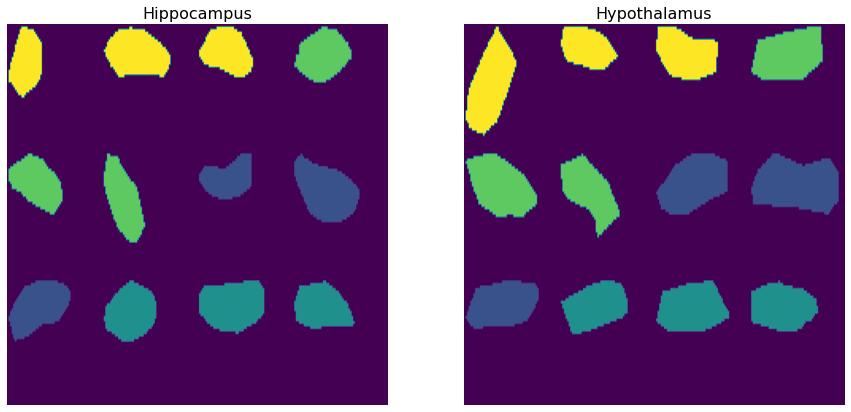

In [11]:
# compile tissues into single object
parsers = list(hipo_parsers.values()) + list(hypo_parsers.values())

# first, we need to determine the maximum dimensions for a single region
x_dim, y_dim = 0, 0
for parser in parsers:

    # get last coordinate
    coordinates = parser.coordinates
    last_coord = coordinates[-1]

    # keep the greatest value in x and y dimensions
    x_dim = np.maximum(x_dim, last_coord[0])
    y_dim = np.maximum(y_dim, last_coord[1])


# round each dimension up to nearest 10
x_dim = x_dim//10 * 10 + 10
y_dim = y_dim//10 * 10 + 30


# plot all data together
tissue_labels = ['Hippocampus', 'Hypothalamus']
tissues = [hipo_parsers, hypo_parsers]


fig, axs = plt.subplots(1, 2, figsize=(15, 7))
GRID_X = 4
GRID_Y = 3

for label, tissue in zip(tissue_labels, tissues):

    # create a small grid to house tissue
    grid = np.zeros((y_dim * GRID_Y, x_dim * GRID_X))

    for i, (ident, parser) in enumerate(tissue.items()):
        start_x = i % 4 * x_dim
        start_y = i // 4 * y_dim
        
        # determine value determined by experimental condition
        map_value = group_map[ident[:-2]]

        for coordinate in parser.coordinates:
            grid[start_y + coordinate[1], start_x + coordinate[0]] = map_value

    if label == 'Hippocampus':
        hipo_grid = copy.copy(grid)
        axs[0].imshow(grid, aspect='auto')
        axs[0].set_title(label, fontsize=16)
        axs[0].axis('off')
    else:
        hypo_grid = copy.copy(grid)
        axs[1].imshow(grid, aspect='auto')
        axs[1].set_title(label, fontsize=16)
        axs[1].axis('off')


fig = plt.gcf()
fig.savefig('./Figures/2D_tissue_array_int_coded.png')
fig.savefig('./Figures/2D_tissue_array_int_coded.svg')

In [8]:
# read in masses to use
df = pd.read_csv('./Data/193 peak 03132022.csv', skiprows=range(8))
df.columns = ['mass', 'interval_da']
df.head()

# calculate tolerance using dalton widths
def cast_ppm(row):
    mass = row.mass
    interval = row['interval_da']

    upper_mass = mass - interval 

    tolerance = ((mass - upper_mass) / mass) * 1e6 
    return tolerance / 2

df.loc[:, 'tolerance'] = df.apply(cast_ppm, axis=1)

673.36


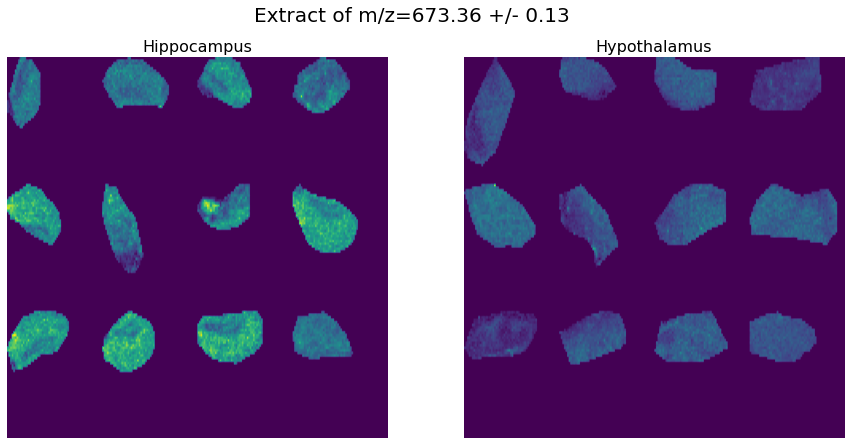

In [9]:
# grab an test mass and example
mass = df.iloc[0, 0]
error = 100

print(mass)
# plot EIC of the example mass for each tissue 
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
GRID_X = 4
GRID_Y = 3

for label, tissue in zip(tissue_labels, tissues):

    # create a small grid to house tissue from each mouse
    grid = np.zeros((y_dim * GRID_Y, x_dim * GRID_X))

    # determine on which pixel to start
    for i, (ident, parser) in enumerate(tissue.items()):
        start_x = i % 4 * x_dim
        start_y = i // 4 * y_dim
        
        # calculate tolerance in m/z
        low, high = mass_tolerance(mass, error)
        tolerance = abs(high-low)

        # grab mass and shape of output
        image = pyimzml.ImzMLParser.getionimage(parser, mass, tolerance)
        shape = image.shape

        # replace a portion of the grid with the image data
        grid[start_y:start_y+shape[0], start_x:start_x+shape[1]] = image

    if label == 'Hippocampus':
        axs[0].imshow(grid, aspect='auto')
        axs[0].set_title(label, fontsize=16)
        axs[0].axis('off')
    else:
        axs[1].imshow(grid, aspect='auto')
        axs[1].set_title(label, fontsize=16)
        axs[1].axis('off')
    plt.suptitle(f'Extract of m/z={mass:.2f} +/- {tolerance:.2f}', fontsize=20)

    fig = plt.gcf()
    fig.savefig('./Figures/Representative_mass_all_sections.png')
    fig.savefig('./Figures/Representative_mass_all_sections.svg')


In [10]:
# for each mass in the list, extract the ion images and concatenate them

hippo_data = []
hypo_data = []

error = 100 # ppm

# check to see if objects exist, otherwise remake them
array_objects = get_files('./Data/objs', exts=['.pkl'])
if len(array_objects) > 0:
    hippo_pkl = [obj for obj in array_objects if re.search('hippocampus_array', obj)][0]
    hypo_pkl = [obj for obj in array_objects if re.search('hypothalamus_array', obj)][0]

    hippo_data = pickle.load(open(hippo_pkl, 'rb'))
    hypo_data = pickle.load(open(hypo_pkl, 'rb'))

else:
    for label, tissue in zip(tissue_labels, tissues):

        # create a small grid to house tissue
        GRID_X = 4
        GRID_Y = 3
        grid = np.zeros((y_dim * GRID_Y, x_dim * GRID_X))

        for mass in df.mass:
            low, high = mass_tolerance(mass, error)
            tolerance = abs(high-low)

            for i, (ident, parser) in enumerate(tissue.items()):
                start_x = i % 4 * x_dim
                start_y = i // 4 * y_dim
                
                image = pyimzml.ImzMLParser.getionimage(parser, mass, tolerance)
                shape = image.shape

                grid[start_y:start_y+shape[0], start_x:start_x+shape[1]] = image


            if label == 'Hippocampus':
                hippo_data.append(grid[np.where(hipo_grid > 0)])
            else:
                hypo_data.append(grid[np.where(hypo_grid > 0)])

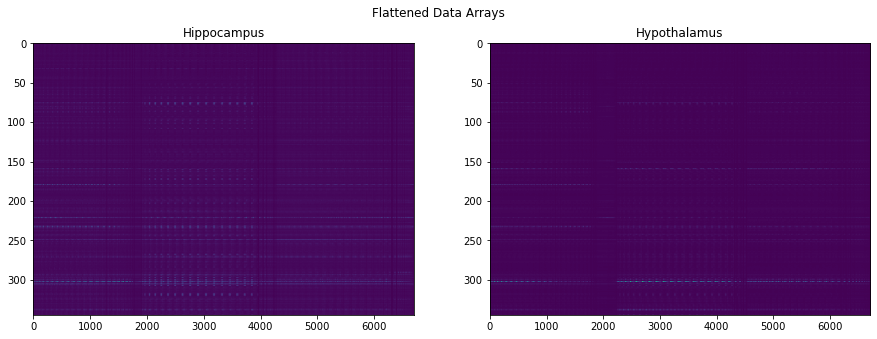

In [11]:
# display the flattened 2D arrays
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(hspace=1)

axs[0].imshow(hippo_data, aspect='auto')
axs[0].set_title('Hippocampus')
axs[1].imshow(hypo_data, aspect='auto')
axs[1].set_title('Hypothalamus')
plt.suptitle('Flattened Data Arrays')

fig = plt.gcf()
fig.savefig('./Figures/flattened_data_arrays.png')
fig.savefig('./Figures/flattened_data_arrays.svg')

## t-SNE Clustering

In [101]:
# check to see if data exists, otherwise create new
objs = get_files('./Data/Objs')

if os.path.join('./Data/Objs', 'hippocampus_array.pkl') in objs:
    X_embedded = pickle.load(open('./Data/objs/hippocampus_embedded_2d.pkl', 'rb'))

else:
    # set seed for reproducibility
    np.random.seed(seed=0)

    # transpose data to cluster by pixel
    data = np.array(hippo_data).T

    # cluster data
    X_embedded = TSNE(n_components=2, perplexity=50, n_iter=4000).fit_transform(data)

    pickle.dump(X_embedded, open('./Data/objs/hippocampus_embedded_2d.pkl', 'wb'))

In [ ]:
def make_grid(parsers, map=None, group=None):

    if group is not None:
        group_colors = dict(zip(group, range(2, len(group)+2)))

    y_dim = 50
    x_dim = 60
    GRID_X = 4
    GRID_Y = 3

    tissue_grid = np.zeros(shape=(y_dim * GRID_Y, x_dim * GRID_X))

    for i, (mouse, tissue) in enumerate(parsers.items()):

        # determine on which pixel to start
        start_x = i % 4 * x_dim
        start_y = i // 4 * y_dim
            
        for _, coordinate in enumerate(tissue.coordinates):
            if group is None or map[mouse] not in group:
                val = 1
            elif map[mouse] in group:
                val = group_colors[map[mouse]]
            
            tissue_grid[start_y + coordinate[1], start_x + coordinate[0]] = val

    return tissue_grid

m = make_grid(hipo_parsers, map=mouse_map, group=['kc'])
plt.imshow(m)

In [ ]:
data_sheet = r'./Data/193 peak 03132022.csv'
import pandas as pd
df = pd.read_csv(data_sheet, skiprows=range(8))
df.columns = ['mass', 'interval_da']

potential_matches = df.mass.to_numpy()

In [ ]:
y_dim = 50
x_dim = 60

GRID_X = 4
GRID_Y = 3


hipo_array_data = []
mask = make_grid(hipo_parsers)
for mass in potential_matches:
    grid = np.zeros(shape=(y_dim * GRID_Y, x_dim * GRID_X))
    for i, tissue in enumerate(hipo_parsers.values()):
        start_x = i % 4 * x_dim
        start_y = i // 4 * y_dim
        im = pyimzml.ImzMLParser.getionimage(tissue, mass, 100)
        shape = im.shape

        grid[start_y:start_y+shape[0], start_x:start_x+shape[1]] = im
    hipo_array_data.append(grid[np.where(mask>0)])
print(len(hipo_array_data))
# set seed for reproducibility
np.random.seed(seed=0)

# transpose data to cluster by pixel
hipo_data = np.array(hipo_array_data).T

from sklearn.manifold import TSNE
# cluster data
hipo_X_embedded = TSNE(n_components=3, perplexity=25, n_iter=2000).fit_transform(hipo_data)

In [ ]:
mask = make_grid(hipo_parsers, map=mouse_map, group=['wc', 'kc', 'ws', 'ks'])
groups = mask[np.where(mask > 0)]
group_labels = [group_map_rev[i-1] for i in groups]

import pandas as pd
hipo_d3 = pd.DataFrame({
    'tSNE_1': hipo_X_embedded[:,0],
    'tSNE_2': hipo_X_embedded[:,1],
    'tSNE_3': hipo_X_embedded[:,2],
    'Treatment Group': group_labels
})


hipo_d3 = hipo_d3[hipo_d3['tSNE_1'] < 60]

import plotly.express as px

fig = px.scatter_3d(
    hipo_d3,
    x='tSNE_1', y='tSNE_2',
    z='tSNE_3',
    color='Treatment Group',
    color_discrete_sequence=[
        "#F5B8D3", # pink
        "#96D1AD", # green
        "#92AFDB", # blue
        "#FECA6D", # yellow
        ],
    width=800, height=800,
)

fig.update_traces(marker=dict(size=5,
                              opacity=1,
                              line=dict(width=0.001,
                                        color='#565656')),
                  selector=dict(mode='markers'))

fig.update_layout(legend= {'itemsizing': 'constant'})

fig.update_layout(
    title={
        'text': "Hippocampus",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.write_html("./figures/Hippocampus_tSNE.html")
fig.show()

In [ ]:
groups = hipo_d3['Treatment Group']
# group_labels = [group_map_rev[i] for i in groups]

color_map = {
    'wc':'#96D1AD',
    'ws':'#FECA6D',
    'ks':'#F5B8D3',
    'kc':'#92AFDB'
}

colors = [color_map[g] for g in groups]

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
s = ax.scatter(hipo_d3['tSNE_3'], hipo_d3['tSNE_2'], hipo_d3['tSNE_1'], c=colors, s=90, edgecolors='#444444')
s.set_edgecolors = s.set_facecolors = lambda *args:None
ax.view_init(20, 75)
plt.title('Hippocampus', fontsize=26)
plt.savefig('./figures/Hippocampus_3d.svg')
plt.show()

In [ ]:
y_dim = 50
x_dim = 60

GRID_X = 4
GRID_Y = 3


hypo_array_data = []
mask = make_grid(hypo_parsers)
for mass in potential_matches:
    grid = np.zeros(shape=(y_dim * GRID_Y, x_dim * GRID_X))
    for i, tissue in enumerate(hypo_parsers.values()):
        start_x = i % 4 * x_dim
        start_y = i // 4 * y_dim
        im = pyimzml.ImzMLParser.getionimage(tissue, mass, 100)
        shape = im.shape

        grid[start_y:start_y+shape[0], start_x:start_x+shape[1]] = im
    hypo_array_data.append(grid[np.where(mask>0)])
print(len(hypo_array_data))
# set seed for reproducibility
np.random.seed(seed=0)

# transpose data to cluster by pixel
hypo_data = np.array(hypo_array_data).T

# cluster data
hypo_X_embedded = TSNE(n_components=3, perplexity=25, n_iter=2000).fit_transform(hypo_data) # was 50 originally

In [ ]:
mask = make_grid(hypo_parsers, map=mouse_map, group=['wc', 'kc', 'ws', 'ks'])
groups = mask[np.where(mask > 0)]
group_labels = [group_map_rev[i-1] for i in groups]

hypo_d3 = pd.DataFrame({
    'tSNE_1': hypo_X_embedded[:,0],
    'tSNE_2': hypo_X_embedded[:,1],
    'tSNE_3': hypo_X_embedded[:,2],
    'Treatment Group': group_labels
})


hypo_d3 = hypo_d3[hypo_d3['tSNE_2'] > -60]

import plotly.express as px

fig = px.scatter_3d(
    hypo_d3,
    x='tSNE_1', y='tSNE_2',
    z='tSNE_3',
    color='Treatment Group',
    color_discrete_sequence=[
        "#F5B8D3", # pink
        "#96D1AD", # green
        "#92AFDB", # blue
        "#FECA6D", # yellow
        ],
    width=800, height=800,
)

fig.update_traces(marker=dict(size=5,
                              opacity=1,
                              line=dict(width=0.001,
                                        color='#565656')),
                  selector=dict(mode='markers'))

fig.update_layout(legend= {'itemsizing': 'constant'})

fig.update_layout(
    title={
        'text': "Hypothalamus",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.write_html("./figures/Hypothalamus_tSNE.html")
fig.show()

In [ ]:
groups = hypo_d3['Treatment Group']
# group_labels = [group_map_rev[i] for i in groups]

color_map = {
    'wc':'#96D1AD',
    'ws':'#FECA6D',
    'ks':'#F5B8D3',
    'kc':'#92AFDB'
}

colors = [color_map[g] for g in hypo_d3['Treatment Group']]

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
s = ax.scatter(hypo_d3['tSNE_3'], hypo_d3['tSNE_2'], hypo_d3['tSNE_1'], c=colors, s=90, edgecolors='#444444')
s.set_edgecolors = s.set_facecolors = lambda *args:None
ax.view_init(20, 150)
plt.title('Hypothalamus', fontsize=26)
plt.savefig('./figures/Hypothalamus_tSNE.svg')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(hspace=1)

axs[0].imshow(hipo_data.T, aspect='auto')
axs[0].set_title('Hippocampus')
axs[1].imshow(hypo_data.T, aspect='auto')
axs[1].set_title('Hypothalamus')
plt.suptitle('Flattened Data Arrays')

fig = plt.gcf()
fig.savefig('./Figures/flattened_data_arrays.png')
fig.savefig('./Figures/flattened_data_arrays.svg')
plt.show()